<a href="https://colab.research.google.com/github/Jezzej/m-r/blob/main/mood_recom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from google.colab import files
import os
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
uploaded = files.upload()

Saving goemotions_2.csv to goemotions_2.csv


# after uploading the dataset proceed towards data inspection

In [ ]:
logging.basicConfig(level = logging.INFO, format = "%(asctime)s - %(levelname)s - %(message)s")

In [ ]:
def load_dataset(fp, ft="csv"):
  if not os.path.exists(fp):
    logging.error(f"file not found : {fp}")
    return None

  try:
    if ft == "csv":
      df = pd.read_csv(fp)
    elif ft == "json":
      df = pd.read_json(fp)
    elif ft == "excel":
      df = pd.read_excel(fp)
    elif ft == "parquet":
      df = pd.read_parquet(fp)
    else:
      logging.error(f"unsupported file {fp}")
      return None


    logging.info(f"dataset loaded sucessfully : {fp}")
    logging.info(f"shape : {df.shape}")
    return df

  except Exception as e:
    logging.error(f"error loading dataset : {str(e)}")
    return None



In [ ]:
fp = "goemotions_2.csv"
df = load_dataset(fp, ft="csv")

if df is not None:
  print(df.head())

                                                text       id  \
0                                        We can hope  ee3o3ko   
1                     Shhh don't give them the idea!  eebl3z7   
2  Thank you so much, kind stranger. I really nee...  ed4fe9l   
3  Ion know but it would be better for you to jus...  efavtdu   
4  I'm honestly surprised. We should have fallen ...  ee2imz2   

               author            subreddit    link_id   parent_id  \
0       darkenseyreth       EdmontonOilers  t3_ag4r9j  t1_ee3mhad   
1   BoinkBoinkEtAliae      MurderedByWords  t3_ah3o76  t1_eeb68lo   
2          savageleaf  raisedbynarcissists  t3_abwh00  t1_ed4etbj   
3           CADDiLLXC              darknet  t3_al4njw   t3_al4njw   
4  CorporalThornberry    CollegeBasketball  t3_afxt6t  t1_ee22nyr   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.547529e+09        62                 False           0  ...     0   
1  1.547777e+09        76                 Fals

now as per the data requiremts we'll refine to make it training worthy

In [ ]:
def explore_data(df):
  print('\n Dataset Overview : ')
  print(df.info())
  print(df.describe())
  print("Shape:", df.shape)
  print("Columns:", df.columns.tolist())

  print('\n Missing Values : ')
  print(df.isnull().sum())

  print('\n Duplicated Rows : ')
  print(df.duplicated().sum())

  print('\n Class Distribution : ')
  plt.figure(figsize=(8,4))
  sns.countplot(y=df['neutral'], palette='pastel')
  plt.show()



 Dataset Overview : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  70000 non-null  object 
 1   id                    70000 non-null  object 
 2   author                70000 non-null  object 
 3   subreddit             70000 non-null  object 
 4   link_id               70000 non-null  object 
 5   parent_id             70000 non-null  object 
 6   created_utc           70000 non-null  float64
 7   rater_id              70000 non-null  int64  
 8   example_very_unclear  70000 non-null  bool   
 9   admiration            70000 non-null  int64  
 10  amusement             70000 non-null  int64  
 11  anger                 70000 non-null  int64  
 12  annoyance             70000 non-null  int64  
 13  approval              70000 non-null  int64  
 14  caring                70000 non-null  int64  
 1

<ipython-input-7-2187443f6d19>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['neutral'], palette='pastel')


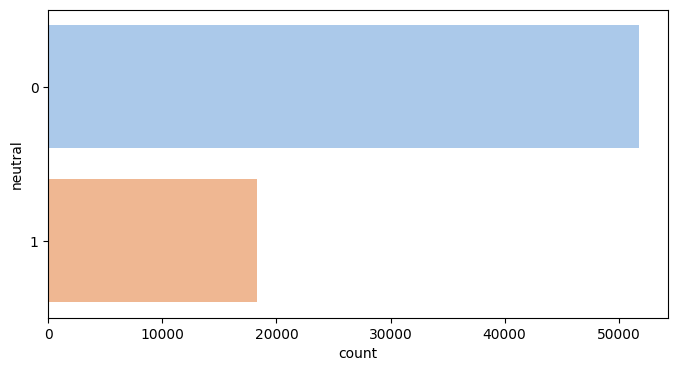

In [ ]:
explore_data(df)

## emotion distribution plot

<ipython-input-9-6a2ff0da3423>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, palette='viridis')


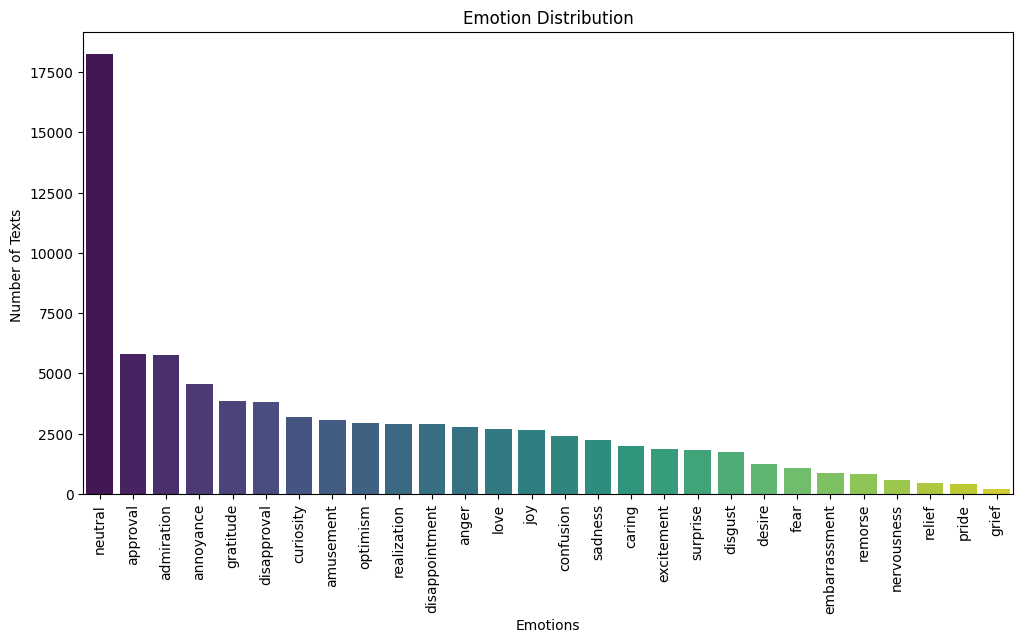

In [ ]:
col = df.columns[9:]
count = df[col].sum().sort_values(ascending=False)


plt.figure(figsize=(12,6))
sns.barplot(x=count.index, y=count.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Emotions')
plt.ylabel('Number of Texts ')
plt.title('Emotion Distribution')
plt.show()

In [ ]:
neutral_count = df['neutral'].sum()
print(f"Number of neutral texts: {neutral_count}")

Number of neutral texts: 18259


Neutral Texts: 18259
Non-Neutral Texts: 51741


<ipython-input-11-de188c94ef67>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Neutral', 'Non-Neutral'], y=[neutral_count, non_neutral_count], palette="coolwarm")


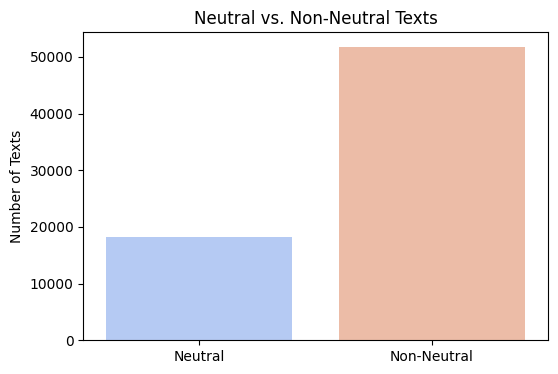

In [ ]:
neutral_count = df['neutral'].sum()
non_neutral_count = len(df) - neutral_count

print(f"Neutral Texts: {neutral_count}")
print(f"Non-Neutral Texts: {non_neutral_count}")

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['Neutral', 'Non-Neutral'], y=[neutral_count, non_neutral_count], palette="coolwarm")
plt.ylabel("Number of Texts")
plt.title("Neutral vs. Non-Neutral Texts")
plt.show()


### we are keeping the neutral column as If a user’s input is neutral, the model should still recommend a movie instead of failing.

keeping at least 5K neytral texts

In [ ]:
from sklearn.utils import resample

In [ ]:
neutral_df = df[df['neutral'] == 1]
non_neutral_df = df[df['neutral'] == 0]

neutral_downsample = resample(neutral_df, replace=False, n_samples=5000, random_state=42)

balanced_df = pd.concat([neutral_downsample, non_neutral_df])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"new shape : {balanced_df.shape}")

new shape : (56741, 37)


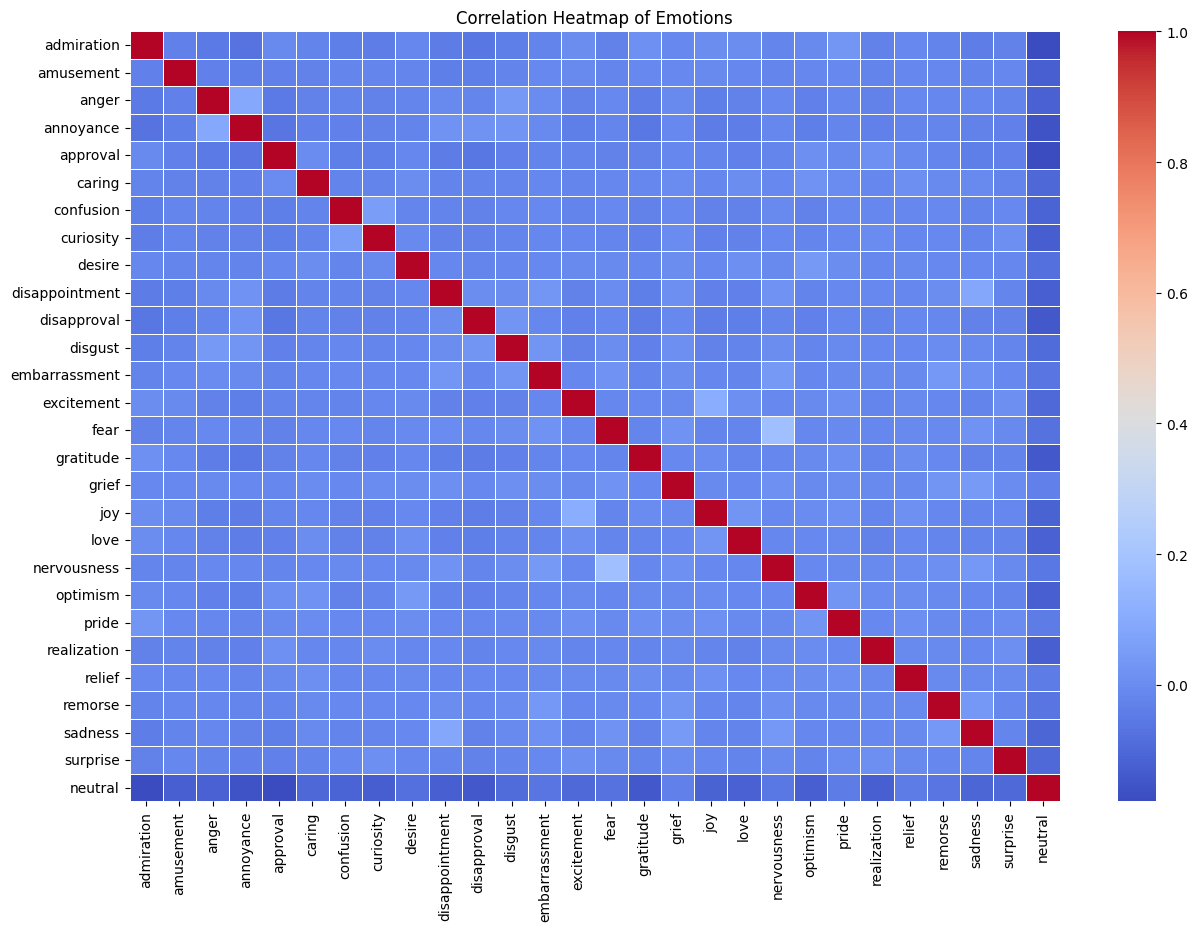

In [ ]:
# Compute correlation between emotions
plt.figure(figsize=(15, 10))
sns.heatmap(df[col].corr(), annot=False, cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Heatmap of Emotions")
plt.show()


checking wheter to drop unclear exaples or not

In [ ]:
unclear_examples = df['example_very_unclear'].value_counts()
print(f"Clear (False) Examples: {unclear_examples.get(False, 0)}")
print(f"Unclear (True) Examples: {unclear_examples.get(True, 0)}")

Clear (False) Examples: 68907
Unclear (True) Examples: 1093


unclear examples visualization

<ipython-input-16-d96d7cb3eaa1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unclear_examples.index, y=unclear_examples.values, palette='pastel')


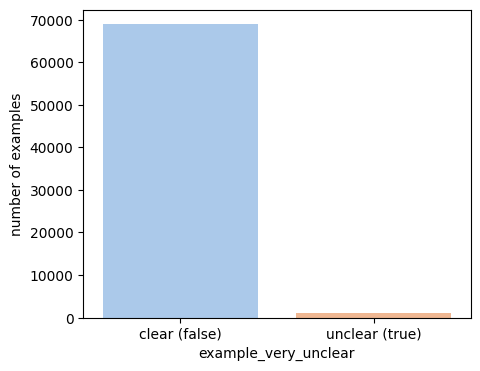

In [ ]:
plt.figure(figsize=(5,4))
sns.barplot(x=unclear_examples.index, y=unclear_examples.values, palette='pastel')
plt.xticks([0,1], ['clear (false)', 'unclear (true)'])
plt.ylabel('number of examples')
plt.show()

dropping unwanted columns

In [ ]:
import re
from sklearn.model_selection import train_test_split

In [ ]:
class DataPreprocessor:
  def __init__(self, drop_columns=None, text_column="text", label_columns=None, unclear_column = 'example_very_unclear'):
    self.drop_columns = drop_columns if drop_columns else []
    self.text_column = text_column
    self.label_columns = label_columns if label_columns.empty is False else []
    self.unclear_column = unclear_column

  def drop_unnecessary_cols(self, df):
    df = df.drop(columns=self.drop_columns, errors="ignore")
    return df

  def drop_unclear_examples(self, df):
    df_filtered = df[df[self.unclear_column] == False].reset_index(drop=True)
    print(f"Removed {len(df) - len(df_filtered)} unclear examples")
    return df_filtered

  def clean_text(self, text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text) #remove multiple spaces
    text = re.sub(r'https?://\S+|www.\S+', '', text) # remove urls
    text = re.sub(r"\s@\S+", " ", text) #remove @ mentiosn
    text = re.sub(r'[^a=z0-9.,!?\'\"]', '', text) # remove special characters
    return text.strip()

  def preprocess_dataframe(self,df):
    df = self.drop_unnecessary_cols(df)
    df = self.drop_unclear_examples(df)
    df[self.text_column] = df[self.text_column].fillna('') # handle missing values
    df[self.text_column] = df[self.text_column].apply(self.clean_text) # appply rex cleaning
    return df

  def split_data(self, df, test_size = 0.2, random_state = 42):
    X = df[self.text_column]
    y = df[self.label_columns]
    for col in self.label_columns:
      if df[col].sum() < 2:
        print(f"Warning: Emotion category '{col}' has less than 2 samples. Removing from label columns.")
        self.label_columns = self.label_columns.drop(col)  # Removing problematic column


    y = df[self.label_columns]  # Update 'y' to use the filtered label columns
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify = y, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

In [ ]:
drop_columns = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id']
text_column = "text"
label_columns = df.columns[9:]


preprocessor = DataPreprocessor(drop_columns=drop_columns, text_column=text_column, label_columns=label_columns)

df_cleaned = preprocessor.preprocess_dataframe(df)

X_train, X_test, y_train, y_test = preprocessor.split_data(df_cleaned)


print(f"data preprocessing completed ")
print(f'training samples : {len(X_train)} | Testing Samples: {len(X_test)}')


Removed 1093 unclear examples


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
emotion_count = df_cleaned[label_columns].sum().sort_values(ascending=True)
print(emotion_count[emotion_count < 5])

plt.figure(figsize=(10, 5))
emotion_count.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Emotion Labels")
plt.ylabel("Number of Examples")
plt.title("Distribution of Emotion Labels in the Dataset")
plt.show()


####To improve generalization and reduce label sparsity, we’ll merge certain emotions into broader categories inspired by Ekman’s Emotion Model.

In [ ]:
class DataPreprocessor:
  def __init__(self, drop_columns=None, text_column="text", label_columns=None, unclear_column = 'example_very_unclear'):
    self.drop_columns = drop_columns if drop_columns else []
    self.text_column = text_column
    self.label_columns = label_columns if label_columns.empty is False else []
    self.unclear_column = unclear_column

  def drop_unnecessary_cols(self, df):
    df = df.drop(columns=self.drop_columns, errors="ignore")
    return df

  def drop_unclear_examples(self, df):
    df_filtered = df[df[self.unclear_column] == False].reset_index(drop=True)
    print(f"Removed {len(df) - len(df_filtered)} unclear examples")
    return df_filtered


  def merge_emotions(self, df, emotion_mapping):
      df = df.copy()

        # Create merged emotion columns
      for new_label, old_labels in emotion_mapping.items():
          df[new_label] = df[old_labels].max(axis=1)  # Merge by taking the max value

        # Keep unmerged emotions
      all_old_labels = set(sum(emotion_mapping.values(), []))  # Flatten the list of merged emotions
      remaining_labels = [col for col in self.label_columns if col not in all_old_labels]

        # Final label columns: merged + unmerged emotions
      final_labels = list(emotion_mapping.keys()) + remaining_labels

      print(f"Merged emotions into {list(emotion_mapping.keys())}, Keeping {len(remaining_labels)} other emotions.")
      return df[[self.text_column] + final_labels]



  def clean_text(self, text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls
    text = re.sub(r'\s@\S+', " ", text) #remove @ mentiosn
    text = re.sub(r"[^a-z0-9.,!?'\"]+", ' ', text) # remove special characters
    text = re.sub(r'\s+', ' ', text).strip() #remove multiple spaces
    return text

  def preprocess_dataframe(self,df, emotion_mapping):
    df = self.drop_unnecessary_cols(df)
    df = self.drop_unclear_examples(df)
    df = self.merge_emotions(df, emotion_mapping)
    df[self.text_column] = df[self.text_column].fillna('') # handle missing values
    df[self.text_column] = df[self.text_column].apply(self.clean_text) # appply rex cleaning
    return df

  def split_data(self, df, test_size = 0.2, random_state = 42):
    X = df[self.text_column]
    y = df[self.label_columns]
    try :
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=test_size, stratify = y, random_state=random_state
    )
    except ValueError:
      print("Warning: Stratified split failed! Using random split.")
      X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
            )
    return X_train, X_test, y_train, y_test

In [ ]:
# Drop unwanted columns
drop_columns = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id']
text_column = "text"
label_columns = df.columns[9:]  # Assuming emotion labels start from index 9

# Define Ekman-inspired emotion mapping
emotion_mapping = {
    "Sadness": ["grief", "remorse", "embarrassment", "sadness"],
    "Joy": ["pride", "joy", "relief"],
    "Fear": ["nervousness", "fear"]
}

# Initialize and Run Preprocessor
preprocessor = DataPreprocessor(drop_columns=drop_columns, text_column=text_column, label_columns=label_columns)

df_cleaned = preprocessor.preprocess_dataframe(df, emotion_mapping)

# Ensure merged and unmerged emotions exist
preprocessor.label_columns = list(df_cleaned.columns[1:])  # Set label columns properly

X_train, X_test, y_train, y_test = preprocessor.split_data(df_cleaned)

print(f"Data Preprocessing Complete!")
print(f"Training Samples: {len(X_train)} | Testing Samples: {len(X_test)}")


Removed 1093 unclear examples
Merged emotions into ['Sadness', 'Joy', 'Fear'], Keeping 19 other emotions.
Data Preprocessing Complete!
Training Samples: 55125 | Testing Samples: 13782


In [ ]:
print(df_cleaned.head())

                                                text  Sadness  Joy  Fear  \
0                                        we can hope        0    0     0   
1                     shhh don't give them the idea!        0    0     0   
2  thank you so much, kind stranger. i really nee...        0    0     0   
3  ion know but it would be better for you to jus...        0    0     0   
4  i'm honestly surprised. we should have fallen ...        0    0     0   

   admiration  amusement  anger  annoyance  approval  caring  ...  \
0           0          0      0          0         0       0  ...   
1           0          0      1          0         0       0  ...   
2           0          0      0          0         0       0  ...   
3           0          0      0          0         0       0  ...   
4           0          0      0          0         0       0  ...   

   disappointment  disapproval  disgust  excitement  gratitude  love  \
0               0            0        0           0     

In [ ]:
df_cleaned.sum()

,0
text,we can hopeshhh don't give them the idea!thank...
Sadness,3938
Joy,3461
Fear,1501
admiration,5773
amusement,3044
anger,2762
annoyance,4557
approval,5785
caring,1985


In [ ]:
print("Unique labels in y_train:\n", y_train.sum(axis=0))
print("Unique labels in y_test:\n", y_test.sum(axis=0))


Unique labels in y_train:
 Sadness            3141
Joy                2795
Fear               1197
admiration         4638
amusement          2427
anger              2219
annoyance          3659
approval           4608
caring             1604
confusion          1917
curiosity          2543
desire             1009
disappointment     2287
disapproval        3024
disgust            1375
excitement         1536
gratitude          3080
love               2150
optimism           2350
realization        2343
surprise           1466
neutral           14582
dtype: int64
Unique labels in y_test:
 Sadness            797
Joy                666
Fear               304
admiration        1135
amusement          617
anger              543
annoyance          898
approval          1177
caring             381
confusion          471
curiosity          647
desire             236
disappointment     607
disapproval        774
disgust            378
excitement         343
gratitude          761
love           

In [ ]:

print(df_cleaned['text'].head(10))  # Show the first 10 text samples


0                                          we can hope
1                       shhh don't give them the idea!
2    thank you so much, kind stranger. i really nee...
3    ion know but it would be better for you to jus...
4    i'm honestly surprised. we should have fallen ...
5    jurisprudence fetishist gets off on technicality.
6                     one of my worst nightmares. ugh.
7                                        is this real?
8    my favorite pod when they are fresh clear. sad...
9    i get wound up over completely imagined conver...
Name: text, dtype: object


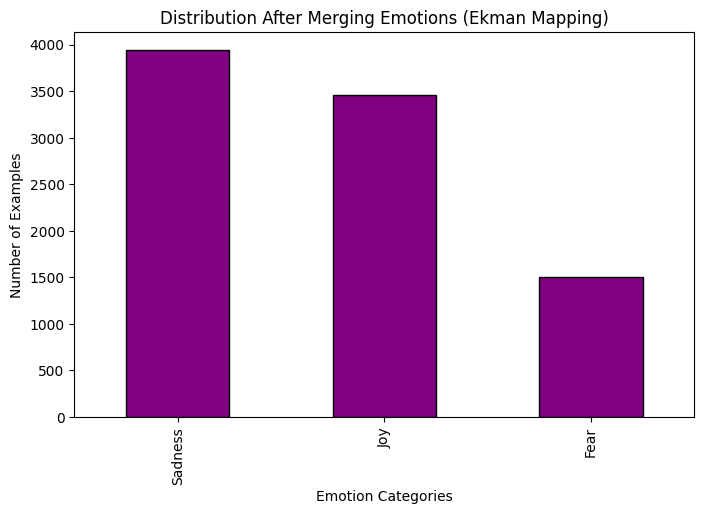

In [ ]:
plt.figure(figsize=(8, 5))
df_cleaned[emotion_mapping.keys()].sum().sort_values(ascending=False).plot(kind="bar", color="purple", edgecolor="black")
plt.xlabel("Emotion Categories")
plt.ylabel("Number of Examples")
plt.title("Distribution After Merging Emotions (Ekman Mapping)")
plt.show()

utilizing the model evaluation approavh and choosing best model based on thier F1-score and accuracy


inintially, im using TF-IDF to transform text into numerical values

WHY TF-IDF?
Captures important words while reducing noise from common words
Works well with models like SVM, Logistic Regression, and Random Forest
Fast and efficient for text classification



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [ ]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
print(" TF-IDF Vectorization Complete!")
print(f"Training Data Shape: {X_train_tfidf.shape}")
print(f"Testing Data Shape: {X_test_tfidf.shape}")

 TF-IDF Vectorization Complete!
Training Data Shape: (55125, 5000)
Testing Data Shape: (13782, 5000)


In [ ]:
vectorizer.get_feature_names_out()[:100]

array(['000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '1st', '20', '20 years', '2016', '2018', '2019', '2020',
       '21', '25', '2nd', '30', '35', '3rd', '40', '45', '4th', '50',
       '500', '60', '80', '90', '99', 'ability', 'able', 'able to',
       'abortion', 'about', 'about being', 'about her', 'about him',
       'about his', 'about how', 'about it', 'about my', 'about name',
       'about that', 'about the', 'about them', 'about this', 'about to',
       'about what', 'about you', 'about your', 'above', 'absolute',
       'absolutely', 'abuse', 'abusive', 'accept', 'accident',
       'accidentally', 'according', 'according to', 'account', 'accurate',
       'across', 'act', 'acting', 'action', 'actions', 'active', 'actual',
       'actually', 'actually really', 'ad', 'add', 'added', 'admit',
       'adorable', 'adult', 'adults', 'advantage', 'advice', 'af',
       'affect', 'afford', 'afraid', 'afraid of', 'after', 'after all',
       'after

In [ ]:
len(vectorizer.get_feature_names_out())

5000

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
count_vect = CountVectorizer(max_features=5000, ngram_range=(1,2))

X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

In [ ]:
print("TF-IDF Vectorization Complete!")
print(f"Training Data Shape: {X_train_count.shape}")
print(f"Testing Data Shape: {X_test_count.shape}")

TF-IDF Vectorization Complete!
Training Data Shape: (55125, 5000)
Testing Data Shape: (13782, 5000)


In [ ]:
count_vect.get_feature_names_out()[10:]

array(['18', '19', '1st', ..., 'youtube', 'yup', 'zero'], dtype=object)

In [ ]:
count_vect = CountVectorizer()

Training logistic Regression

random_state : ensure model produces sam resuts everytime run it

solver : how model finds the best parameters basically for algo optimization

it dependes on the dataset

mx_iter : controls model's parameters updation during training (how many times model updates its parameter(labels))

need to mitigate convergence value default using 1000.

ValueError                                Traceback (most recent call last)
<ipython-input-38-e6f93ac4ab10> in <cell line: 0>()
      2     random_state=42, solver = 'saga', max_iter=1000
      3 )
----> 4 log_reg.fit(X_train_tfidf, y_train)

5 frames
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py in column_or_1d(y, dtype, warn, device)
   1483         )
   1484
-> 1485     raise ValueError(
   1486         "y should be a 1d array, got an array of shape {} instead.".format(shape)
   1487     )

ValueError: y should be a 1d array, got an array of shape (55125, 22) instead.

--------------------------------------

log_reg -> does not supports multi-label classification (where one sample can belong to multiple categories).

multi-class is possible but not mult-label better to use OvR if really want to do logistic regression



In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
log_reg = OneVsRestClassifier(LogisticRegression(
    random_state=42, solver = 'saga', max_iter=1000
))
log_reg.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, random_state=42,
                                                 solver='saga'))

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
pred_labels = log_reg.predict(X_test_tfidf)
f1_micro = f1_score(y_test, pred_labels, average="micro")
f1_macro = f1_score(y_test, pred_labels, average="macro")

In [ ]:
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")

F1 Micro: 0.2133
F1 Macro: 0.1692


In [ ]:
log_reg = OneVsRestClassifier(LogisticRegression(
    random_state=42, class_weight="balanced", solver = 'saga', max_iter=5000
))
log_reg.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
pred_labels = log_reg.predict(X_test_tfidf)
f1_micro = f1_score(y_test, pred_labels, average="micro")
f1_macro = f1_score(y_test, pred_labels, average="macro")

In [ ]:
print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel="linear"),
    "Naïve Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

In [ ]:
y_train_single = y_train.idxmax(axis=1)  # Select the highest emotion score
y_test_single = y_test.idxmax(axis=1)


In [ ]:
results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...\n")

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Predictions
    y_pred = model.predict(X_test_tfidf)

    # Evaluation
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    results[name] = report

    # Print summary
    print(f"🔹 {name} Performance:")
    print(classification_report(y_test, y_pred))

# 4️⃣ Find the Best Model
best_model = max(results, key=lambda x: results[x]["macro avg"]["f1-score"])
print(f"\n🏆 Best Model: {best_model}")

In [ ]:
def train_evaluate_models(X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\n🚀 Training {name}...")

        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('classifier', model)
        ])

        # Train Model
        pipeline.fit(X_train, y_train)

        # Evaluate Model
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        # Store Results
        results[name] = {
            "accuracy": accuracy,
            "report": report
        }

        print(f"\n Performance of {name}:")
        print(report)

    return results

In [ ]:
model_results = train_evaluate_models(X_train, X_test, y_train, y_test)

best_model = max(model_results, key=lambda k: model_results[k]['accuracy'])
print(f"\n Best Model: {best_model} with Accuracy: {model_results[best_model]['accuracy']:.4f}")

In [ ]:
class MoodClassificationPipeline:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {
            "Logistic Regression": LogisticRegression(),
            "Naïve Bayes": MultinomialNB(),
            "SVM": SVC(kernel="linear"),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
        }

    def train_and_evaluate(self):
        """Train models and evaluate their performance."""
        results = []

        for model_name, model in self.models.items():
            print(f"\n Training {model_name}...")
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)

            # Calculate performance metrics
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred, average="weighted", zero_division=0)
            recall = recall_score(self.y_test, y_pred, average="weighted", zero_division=0)
            f1 = f1_score(self.y_test, y_pred, average="weighted", zero_division=0)

            results.append({
                "Model": model_name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1
            })

            print(f"\n Performance for {model_name}:")
            print(f" Accuracy: {accuracy:.4f}")
            print(f" Precision: {precision:.4f}")
            print(f" Recall: {recall:.4f}")
            print(f" F1-Score: {f1:.4f}")

        return pd.DataFrame(results)

In [ ]:
X = df_cleaned["text"]
y = df_cleaned.iloc[:, 1:]



In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(tf.config.list_physical_devices('GPU'))

In [ ]:
print("Gpu available : ", len(tf.config.list_physical_devices('GPU')))
